# Setup

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils import prune
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import torchbnn as bnn
from torchhk import transform_model
import torch.nn.functional as F

In [4]:
sigmoid = lambda x: 1/(1 + np.exp (-x))

def gen_data(n, d):
    x = np.random.randn(n, d)
    #x = np.random.beta(5, 1, size=(n, d))
    z = np.empty((n,2))
    z[:,0] = 1/(1 + np.exp (1 - x[:,0]))
    z[:,1] = 1/(1 + np.exp (x[:,1] - x[:,2]))
    y = np.empty((n,1))
    u = sigmoid(2*z[:,0] - z[:,1])
    y = np.where(u>0.5,1,0).reshape(-1,1)
    return x, y, np.expand_dims(u, axis=1)

x, y, u = gen_data(1000, 3)

In [5]:
class BCL(nn.Module):
    """Simple model with two layers
    1st layer: target data-generating process
    initializes fixed weights, biases
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BCL, self).__init__()

        # randomly initialized weights
        self.layer_1 = nn.Linear(input_dim, hidden_dim, bias=True)
        self.layer_2 = nn.Linear(hidden_dim, output_dim, bias=True)

        # sets initial weights; w1 used below to set mask
        w1 = torch.Tensor(np.asarray([[1, 0, 0], [0, -1, 1]]))  # dim 2 x 3
        w2 = torch.Tensor(np.asarray([[2, -1]]))  # dim 1 x 2
        b1 = torch.Tensor(np.asarray([[-1, 0]]))
        b2 = torch.Tensor(np.asarray([0]))


        maskw1 = torch.abs(torch.sign(w1))  # converts non-binary weights to binary mask

        self.layer_1.weight.data = w1
        self.layer_2.weight.data = w2
        self.layer_1.bias.data = b1
        self.layer_2.bias.data = b2

        # masked weights do NOT update
        # n.b. can re-use w1 as mask matrix needs to be {0, 1} binary
        prune.custom_from_mask(
            self.layer_1, name='weight', mask=maskw1)

    def sep_train_layer(self, layer=0):
        if layer==0:
            for param in self.layer_1.parameters():
                param.requires_grad = True
            for param in self.layer_2.parameters():
                param.requires_grad = True
        elif layer==1:
            for param in self.layer_1.parameters():
                param.requires_grad = True
            for param in self.layer_2.parameters():
                param.requires_grad = False
        elif layer==2:
            for param in self.layer_1.parameters():
                param.requires_grad = False
            for param in self.layer_2.parameters():
                param.requires_grad = True
        else:
            raise ValueError("layer must be 0, 1 or 2")

    def forward(self, inputs):
        x = self.layer_1(inputs)
        x = torch.sigmoid(x)
        x = self.layer_2(x)
        return torch.sigmoid(x)

# Ground truth

In [6]:
# initialize model
model = BCL(input_dim=3, hidden_dim=2, output_dim=1)

In [7]:
model

BCL(
  (layer_1): Linear(in_features=3, out_features=2, bias=True)
  (layer_2): Linear(in_features=2, out_features=1, bias=True)
)

In [8]:
def accuracy(model, inputs, labels):
    with torch.no_grad():
        outputs = model(inputs)
        predicted = outputs>0.5
        total = labels.shape[0]
        correct = torch.sum(labels == predicted).item()
        print('Accuracy: {:.2f}%'.format(correct / total * 100))

print("GROUND TRUTH:")
accuracy(model, torch.Tensor(x), torch.Tensor(y))

GROUND TRUTH:
Accuracy: 100.00%


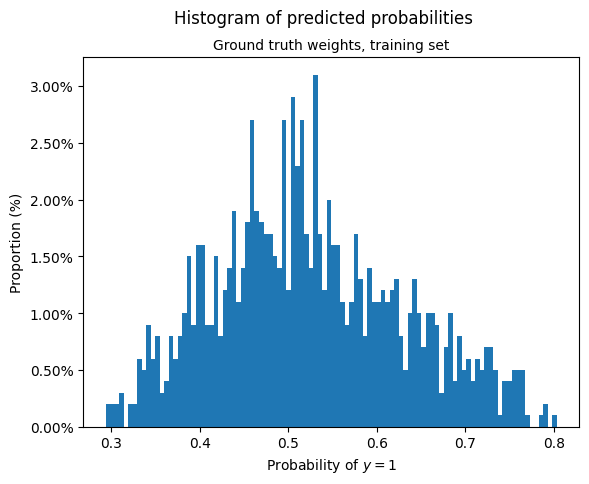

In [9]:
def hist(model, inputs, title):
    with torch.no_grad():
        # convert model(inputs) to numpy array
        outputs = model(inputs)
        outputs = outputs.numpy()
    # CHANGE Y LABEL
    plt.hist(outputs, weights=np.ones(len(outputs)) / len(outputs), bins=100)
    plt.suptitle("Histogram of predicted probabilities", fontsize=12),
    plt.title(title, fontsize=10)
    plt.xlabel("Probability of $y=1$")
    plt.ylabel("Proportion (%)")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.show()

hist(model, torch.Tensor(x), "Ground truth weights, training set")

# Two layer masked model with end-to-end training

In [10]:
def hinge_loss(outputs, labels):
    labels_fix = 2*labels - 1
    outputs_fix = 2*outputs - 1
    loss = torch.max(torch.zeros_like(outputs), 1 - labels_fix*outputs_fix)
    return torch.mean(loss)

In [11]:
def smoothing(labels, smoothing_factor=0.1):
    smoothing_factor = 2*smoothing_factor
    return labels*(1-smoothing_factor) + 0.5*smoothing_factor

In [20]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    weight_decay: 0
)

In [14]:
# number of epochs
epochs = 5_000
# initialize model
model = BCL(input_dim=3, hidden_dim=2, output_dim=1)
# initialize optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.1, weight_decay=0)
# initialize loss function
criterion = nn.BCELoss()

inputs = torch.Tensor(x)
labels = torch.Tensor(y)

def train_end_to_end(model, inputs, labels, optimizer, epochs, criterion, verbose=False):
    losses = []

    # loop over epochs
    for i in range(epochs):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if verbose:
            # print statistics
            if i % 1000 == 0:
                print('Epoch: {} | Loss: {:.6f}'.format(i, loss.item()))

    return losses, model

losses, model = train_end_to_end(model, inputs, labels, optimizer, epochs, criterion, verbose=True)

Epoch: 0 | Loss: 0.539894
Epoch: 1000 | Loss: 0.056459
Epoch: 2000 | Loss: 0.036321
Epoch: 3000 | Loss: 0.026774
Epoch: 4000 | Loss: 0.020781


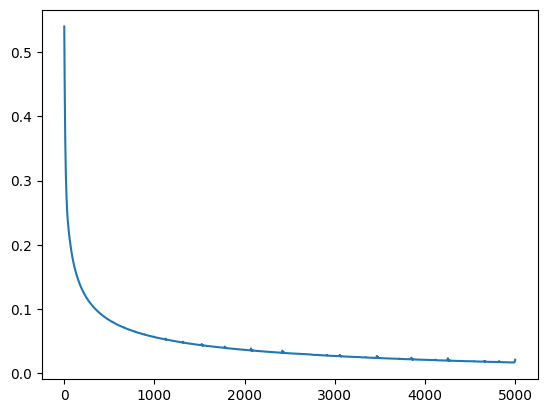

In [15]:
plt.plot(losses)

In [16]:
print("TRAIN:")
accuracy(model, inputs, labels)

TRAIN:
Accuracy: 99.60%


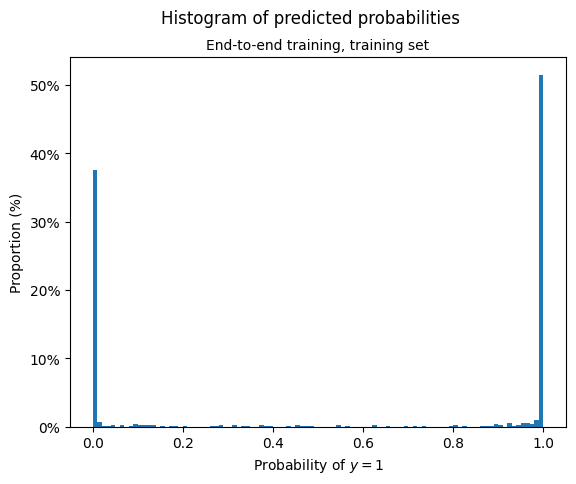

In [17]:
hist(model, inputs, "End-to-end training, training set")

TEST:
Accuracy: 99.70%


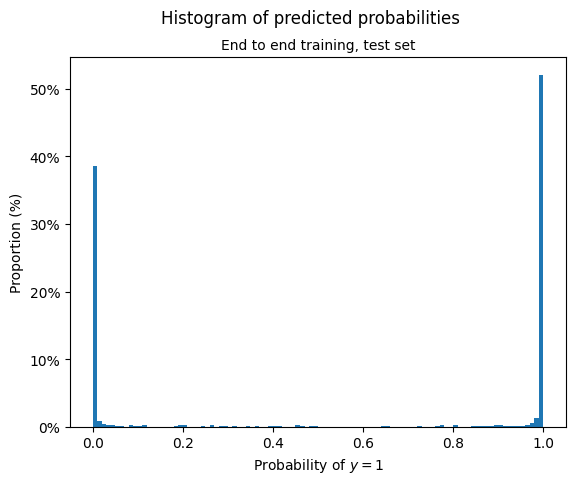

In [18]:
x, y, u = gen_data(1000, 3)
print("TEST:")
accuracy(model, torch.Tensor(x), torch.Tensor(y))
hist(model, torch.Tensor(x), "End to end training, test set")

In [19]:
def print_weights(model):

    print("Layer 1 weights")
    print(model.layer_1.weight.data)

    print("\nLayer 1 bias")
    print(model.layer_1.bias.data)

    print("\nLayer 2 weights")
    print(model.layer_2.weight.data)

    print("\nLayer 2 bias")
    print(model.layer_2.bias.data)

print_weights(model)

Layer 1 weights
tensor([[ 1.7457,  0.0000,  0.0000],
        [ 0.0000, -1.4169,  1.4337]])

Layer 1 bias
tensor([[0.0709, 0.2790]])

Layer 2 weights
tensor([[ 94.1946, -79.0985]])

Layer 2 bias
tensor([1.2872])


# Two layer masked model with separated training

In [184]:
# initialize model
model = BCL(input_dim=3, hidden_dim=2, output_dim=1)
# initialize optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.1)
# initialize loss function
criterion = nn.BCELoss()
# train model
epochs = 5_000

# initialize lists to store loss
losses = []

def train_sep_layers(model, inputs, labels, optimizer, epochs, criterion, verbose=False):
    losses = []

    # loop over epochs
    for layer in [1, 2]:
        model.sep_train_layer(layer)
        for i in range(epochs):

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # store loss
            losses.append(loss.item())

            # print statistics
            if verbose:
                if i % 1000 == 0:
                    print('Layer: {} | Epoch: {} | Loss: {:.6f}'.format(layer, i, loss.item()))

    return losses, model

losses, model = train_sep_layers(model, inputs, labels, optimizer, epochs, criterion, verbose=True)

Layer: 1 | Epoch: 0 | Loss: 0.539835
Layer: 1 | Epoch: 1000 | Loss: 0.421198
Layer: 1 | Epoch: 2000 | Loss: 0.421053
Layer: 1 | Epoch: 3000 | Loss: 0.421006
Layer: 1 | Epoch: 4000 | Loss: 0.420989
Layer: 2 | Epoch: 0 | Loss: 0.420981
Layer: 2 | Epoch: 1000 | Loss: 0.237144
Layer: 2 | Epoch: 2000 | Loss: 0.237078
Layer: 2 | Epoch: 3000 | Loss: 0.237061
Layer: 2 | Epoch: 4000 | Loss: 0.237056


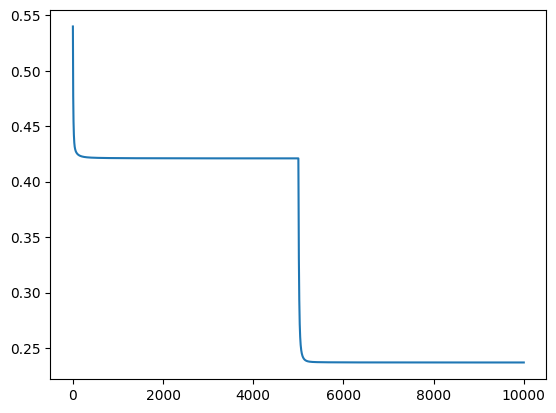

In [185]:
plt.plot(losses)

TRAIN:
Accuracy: 88.70%


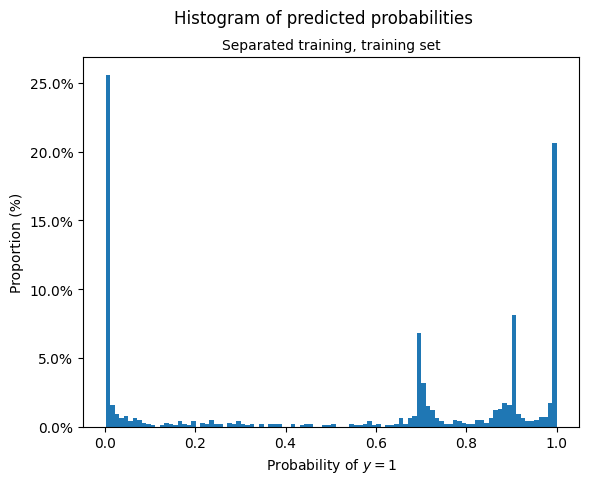

In [186]:
print("TRAIN:")
accuracy(model, inputs, labels)
hist(model, inputs, "Separated training, training set")

TEST:
Accuracy: 87.20%


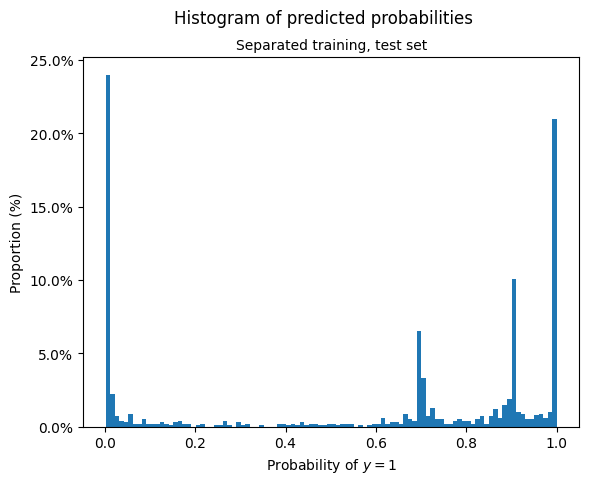

In [187]:
print("TEST:")
x, y, u = gen_data(1000, 3)
accuracy(model, torch.Tensor(x), torch.Tensor(y))
hist(model, torch.Tensor(x), "Separated training, test set")

In [188]:
print_weights(model)

Layer 1 weights
tensor([[ 7.8599,  0.0000,  0.0000],
        [ 0.0000, -8.6072,  7.4369]])

Layer 1 bias
tensor([[-1.1113,  1.2363]])

Layer 2 weights
tensor([[ 8.4529, -7.0538]])

Layer 2 bias
tensor([0.8480])


# Average weights - end-to-end training

In [189]:
x, y, u = gen_data(1000, 3)
inputs = torch.Tensor(x)
labels = torch.Tensor(y)

In [190]:
# initialize model
model = BCL(input_dim=3, hidden_dim=2, output_dim=1)

# initialize optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.1)

# initialize loss function
criterion = nn.BCELoss()

epochs = 1_000
iterations = 50

def averaged_models(training_func, model, optimizer, criterion, epochs, iterations, random=False):

    # initialize tensors to store weights
    layer_1_weights = torch.empty(iterations, 2, 3)
    layer_1_bias = torch.empty(iterations, 2)
    layer_2_weights = torch.empty(iterations, 1, 2)
    layer_2_bias = torch.empty(iterations, 1)
    predictions = torch.empty(iterations, 1000)

    for i in range(iterations):
        # train model
        losses, model = training_func(model, inputs, labels, optimizer, epochs, criterion, verbose=False)

        # store weights
        layer_1_weights[i] = model.layer_1.weight.data
        layer_1_bias[i] = model.layer_1.bias.data
        layer_2_weights[i] = model.layer_2.weight.data
        layer_2_bias[i] = model.layer_2.bias.data

        # store predictions
        predictions[i] = model(inputs).squeeze()

        # re-initialize model
        model = BCL(input_dim=3, hidden_dim=2, output_dim=1)
        if random:
            model.layer_1.weight.data = torch.randn(2, 3)
            model.layer_1.bias.data = torch.randn(2)
            model.layer_2.weight.data = torch.randn(1, 2)
            model.layer_2.bias.data = torch.randn(1)

        optimizer = optim.AdamW(model.parameters(), lr=0.1)

    # Take averages along axis 0
    layer_1_weights = layer_1_weights.mean(axis=0)
    layer_1_bias = layer_1_bias.mean(axis=0)
    layer_2_weights = layer_2_weights.mean(axis=0)
    layer_2_bias = layer_2_bias.mean(axis=0)

    # Predictions
    predictions = predictions.mean(axis=0)
    avg_prediction_error = np.mean(np.abs(predictions.detach().numpy() - np.squeeze(u, axis=1)))
    train_accuracy = np.mean(np.round(predictions.detach().numpy()) == np.squeeze(y, axis=1))
    print(f"Train accuracy: {train_accuracy*100}")

    return layer_1_weights, layer_1_bias, layer_2_weights, layer_2_bias, avg_prediction_error, predictions

In [191]:
layer_1_weights, layer_1_bias, layer_2_weights, layer_2_bias, avg_prediction_error, predictions = averaged_models(train_end_to_end, model, optimizer, criterion, epochs, iterations, random=False)

print("\nAverage prediction error: {:.4f}".format(avg_prediction_error))

print("\nAverage Layer 1 weights")
print(layer_1_weights)

print("\nAverage Layer 1 bias")
print(layer_1_bias)

print("\nAverage Layer 2 weights")
print(layer_2_weights)

print("\nAverage Layer 2 bias")
print(layer_2_bias)

Train accuracy: 98.6

Average prediction error: 0.3611

Average Layer 1 weights
tensor([[ 2.2019,  0.0000,  0.0000],
        [ 0.0000, -1.7313,  1.7591]])

Average Layer 1 bias
tensor([-0.0930,  0.1682])

Average Layer 2 weights
tensor([[ 21.0125, -18.1438]])

Average Layer 2 bias
tensor([1.0439])


# Average weights - separated training

In [192]:
# initialize model
model = BCL(input_dim=3, hidden_dim=2, output_dim=1)

# initialize optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.1)

# initialize loss function
criterion = nn.BCELoss()

epochs = 1_000
iterations = 50

layer_1_weights, layer_1_bias, layer_2_weights, layer_2_bias, avg_prediction_error, predictions = averaged_models(train_sep_layers, model, optimizer, criterion, epochs, iterations)

print("Average prediction error: {:.4f}".format(avg_prediction_error))

print("\nAverage Layer 1 weights")
print(layer_1_weights)

print("\nAverage Layer 1 bias")
print(layer_1_bias)

print("\nAverage Layer 2 weights")
print(layer_2_weights)

print("\nAverage Layer 2 bias")
print(layer_2_bias)

Train accuracy: 90.7
Average prediction error: 0.3306

Average Layer 1 weights
tensor([[ 6.7420,  0.0000,  0.0000],
        [ 0.0000, -8.3962,  8.1047]])

Average Layer 1 bias
tensor([-1.1154,  1.5593])

Average Layer 2 weights
tensor([[10.5596, -9.0661]])

Average Layer 2 bias
tensor([1.0567])


# Ensemble models with random initialisations

In [193]:
x, y, u = gen_data(1000, 3)
inputs = torch.Tensor(x)
labels = torch.Tensor(y)

# initialize model
model = BCL(input_dim=3, hidden_dim=2, output_dim=1)

# initialize optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.1)

# initialize loss function
criterion = nn.BCELoss()

epochs = 1_000
iterations = 50

layer_1_weights, layer_1_bias, layer_2_weights, layer_2_bias, avg_prediction_error, predictions = averaged_models(train_end_to_end, model, optimizer, criterion, epochs, iterations, random=True)

print("\nAverage prediction error: {:.4f}".format(avg_prediction_error))

print("\nAverage Layer 1 weights")
print(layer_1_weights)

print("\nAverage Layer 1 bias")
print(layer_1_bias)

print("\nAverage Layer 2 weights")
print(layer_2_weights)

print("\nAverage Layer 2 bias")
print(layer_2_bias)

Train accuracy: 98.8

Average prediction error: 0.3421

Average Layer 1 weights
tensor([[ 1.3773,  0.0000,  0.0000],
        [ 0.0000, -0.3939,  0.3981]])

Average Layer 1 bias
tensor([-0.0187,  0.0566])

Average Layer 2 weights
tensor([[11.0812, -4.4648]])

Average Layer 2 bias
tensor([-1.5415])


In [194]:
# initialize model
model = BCL(input_dim=3, hidden_dim=2, output_dim=1)

# initialize optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.1)

# initialize loss function
criterion = nn.BCELoss()

epochs = 1_000
iterations = 20

layer_1_weights, layer_1_bias, layer_2_weights, layer_2_bias, avg_prediction_error, model = averaged_models(train_sep_layers, model, optimizer, criterion, epochs, iterations)

print("Average prediction error: {:.4f}".format(avg_prediction_error))

print("\nAverage Layer 1 weights")
print(layer_1_weights)

print("\nAverage Layer 1 bias")
print(layer_1_bias)

print("\nAverage Layer 2 weights")
print(layer_2_weights)

print("\nAverage Layer 2 bias")
print(layer_2_bias)

Train accuracy: 89.7
Average prediction error: 0.3211

Average Layer 1 weights
tensor([[ 6.8956,  0.0000,  0.0000],
        [ 0.0000, -7.2510,  7.8780]])

Average Layer 1 bias
tensor([-0.7299,  2.3319])

Average Layer 2 weights
tensor([[ 8.2395, -6.9238]])

Average Layer 2 bias
tensor([0.8734])


# BNN

In [210]:
class BNN(nn.Module):
    """Simple model with two layers
    1st layer: target data-generating process
    initializes fixed weights, biases
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BNN, self).__init__()

        # randomly initialized weights
        self.layer_1 = bnn.BayesLinear(prior_mu=0, prior_sigma=2, in_features=input_dim, out_features=hidden_dim, bias=True)
        self.layer_2 = bnn.BayesLinear(prior_mu=0, prior_sigma=2, in_features=hidden_dim, out_features=output_dim, bias=True)

        # sets initial weights; w1 used below to set mask
        w1 = torch.Tensor(np.asarray([[1, 0, 0], [0, -1, 1]]))  # dim 2 x 3
        w2 = torch.Tensor(np.asarray([[2, -1]]))  # dim 1 x 2
        b1 = torch.Tensor(np.asarray([[-1, 0]]))
        b2 = torch.Tensor(np.asarray([0]))


        maskw1 = torch.abs(torch.sign(w1))  # converts non-binary weights to binary mask

        self.layer_1.weight_mu.data = w1
        self.layer_2.weight_mu.data = w2
        self.layer_1.bias_mu.data = b1
        self.layer_2.bias_mu.data = b2

        # masked weights do NOT update
        # n.b. can re-use w1 as mask matrix needs to be {0, 1} binary
        prune.custom_from_mask(
            self.layer_1, name='weight_mu', mask=maskw1)
        prune.custom_from_mask(
            self.layer_1, name='weight_log_sigma', mask=maskw1)

    def sep_train_layer(self, layer=0):
        if layer==0:
            for param in self.layer_1.parameters():
                param.requires_grad = True
            for param in self.layer_2.parameters():
                param.requires_grad = True
        elif layer==1:
            for param in self.layer_1.parameters():
                param.requires_grad = True
            for param in self.layer_2.parameters():
                param.requires_grad = False
        elif layer==2:
            for param in self.layer_1.parameters():
                param.requires_grad = False
            for param in self.layer_2.parameters():
                param.requires_grad = True
        else:
            raise ValueError("layer must be 0, 1 or 2")

    def forward(self, inputs):
        x = self.layer_1(inputs)
        x = torch.sigmoid(x)
        x = self.layer_2(x)
        return torch.sigmoid(x)

In [211]:
x, y, u = gen_data(1000, 3)

model = BNN(input_dim=3, hidden_dim=2, output_dim=1)

ce_loss = nn.BCELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.1

optimizer = optim.Adam(model.parameters(), lr=0.01)
x = torch.Tensor(x)
y = torch.Tensor(y)

for step in range(3000):
    pre = model(x)
    ce = ce_loss(pre, y)
    kl = kl_loss(model)
    cost = ce + kl_weight*kl

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

_, predicted = torch.max(pre.data, 1)
total = y.size(0)
correct = (torch.round(pre) == y).sum()
print('- Accuracy: %.1f %%' % (100 * float(correct) / total))
print('- CE : %2.2f, KL : %2.2f' % (ce.item(), kl.item()))

- Accuracy: 90.3 %
- CE : 0.22, KL : 1.63


In [212]:
model.layer_1.weight_mu

tensor([[ 4.4660,  0.0000,  0.0000],
        [ 0.0000, -2.4642,  2.6890]], grad_fn=<MulBackward0>)

In [213]:
model.layer_1.bias_mu

Parameter containing:
tensor([[-0.0902,  0.0493]], requires_grad=True)

In [214]:
model.layer_2.weight_mu

Parameter containing:
tensor([[ 4.8186, -4.3776]], requires_grad=True)

In [215]:
model.layer_2.bias_mu

Parameter containing:
tensor([0.3861], requires_grad=True)

In [216]:
def draw_plot(predicted) :
    fig = plt.figure(figsize = (16, 5))

    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    z1_plot = ax1.scatter(x[:, 0], x[:, 1], c = u)
    z2_plot = ax2.scatter(x[:, 0], x[:, 1], c = predicted)

    plt.colorbar(z1_plot,ax=ax1)
    plt.colorbar(z2_plot,ax=ax2)

    ax1.set_title("REAL")
    ax2.set_title("PREDICT")

    plt.show()

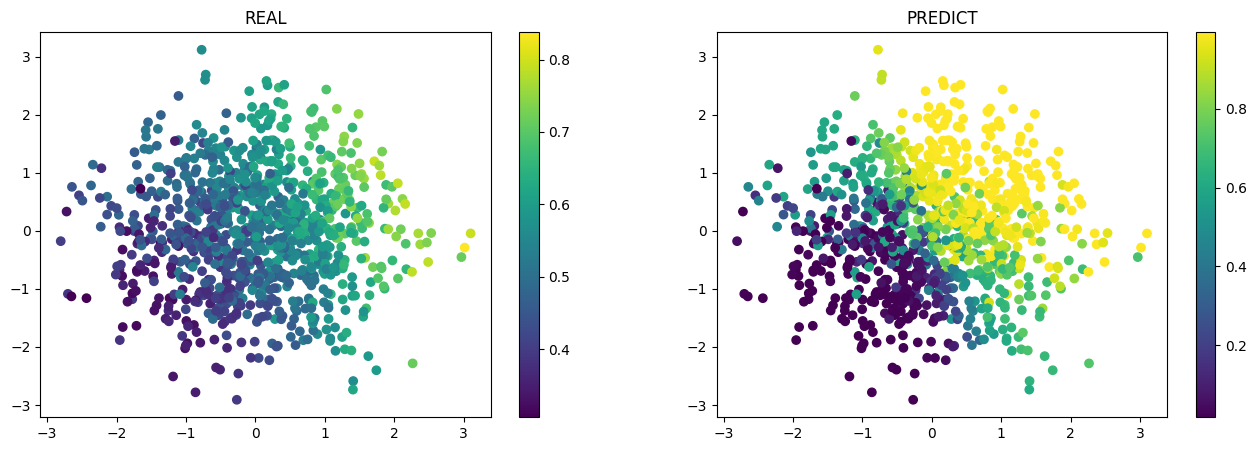

In [217]:
pre = model(x)
_, predicted = torch.max(pre.data, 1)
draw_plot(pre.detach().numpy())